## Importing the dependencies

In [438]:
!pip install lightgbm

In [504]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

%config InlineBackend.figure_format = 'retina'

# to display all columns and rows:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);  # to display all columns and rows
pd.set_option('display.float_format', lambda x: '%.2f' % x) # The number of numbers that will be shown after the comma.

## Loading the dataset

In [440]:
df = pd.read_csv('diabetes.csv')

## Exploratory Data Analysis

In [441]:
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
189,5,139,80,35,160,31.60,0.36,25,1
31,3,158,76,36,245,31.60,0.85,28,1
690,8,107,80,0,0,24.60,0.86,34,0
392,1,131,64,14,415,23.70,0.39,21,0
507,1,130,60,23,170,28.60,0.69,21,0


In [442]:
df.shape

(768, 9)

In [443]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [444]:
df.describe([0.10,0.25,0.50,0.75,0.90,0.95,0.99])

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
10%,0.00,85.00,54.00,0.00,0.00,23.60,0.17,22.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
90%,9.00,167.00,88.00,40.00,210.00,41.50,0.88,51.00,1.00
95%,10.00,181.00,90.00,44.00,293.00,44.39,1.13,58.00,1.00


In [445]:
df.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [446]:
df.Outcome.value_counts() * 100 / len(df)

0   65.10
1   34.90
Name: Outcome, dtype: float64

In [447]:
# missing values
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [448]:
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)

In [449]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [450]:
!pip install missingno

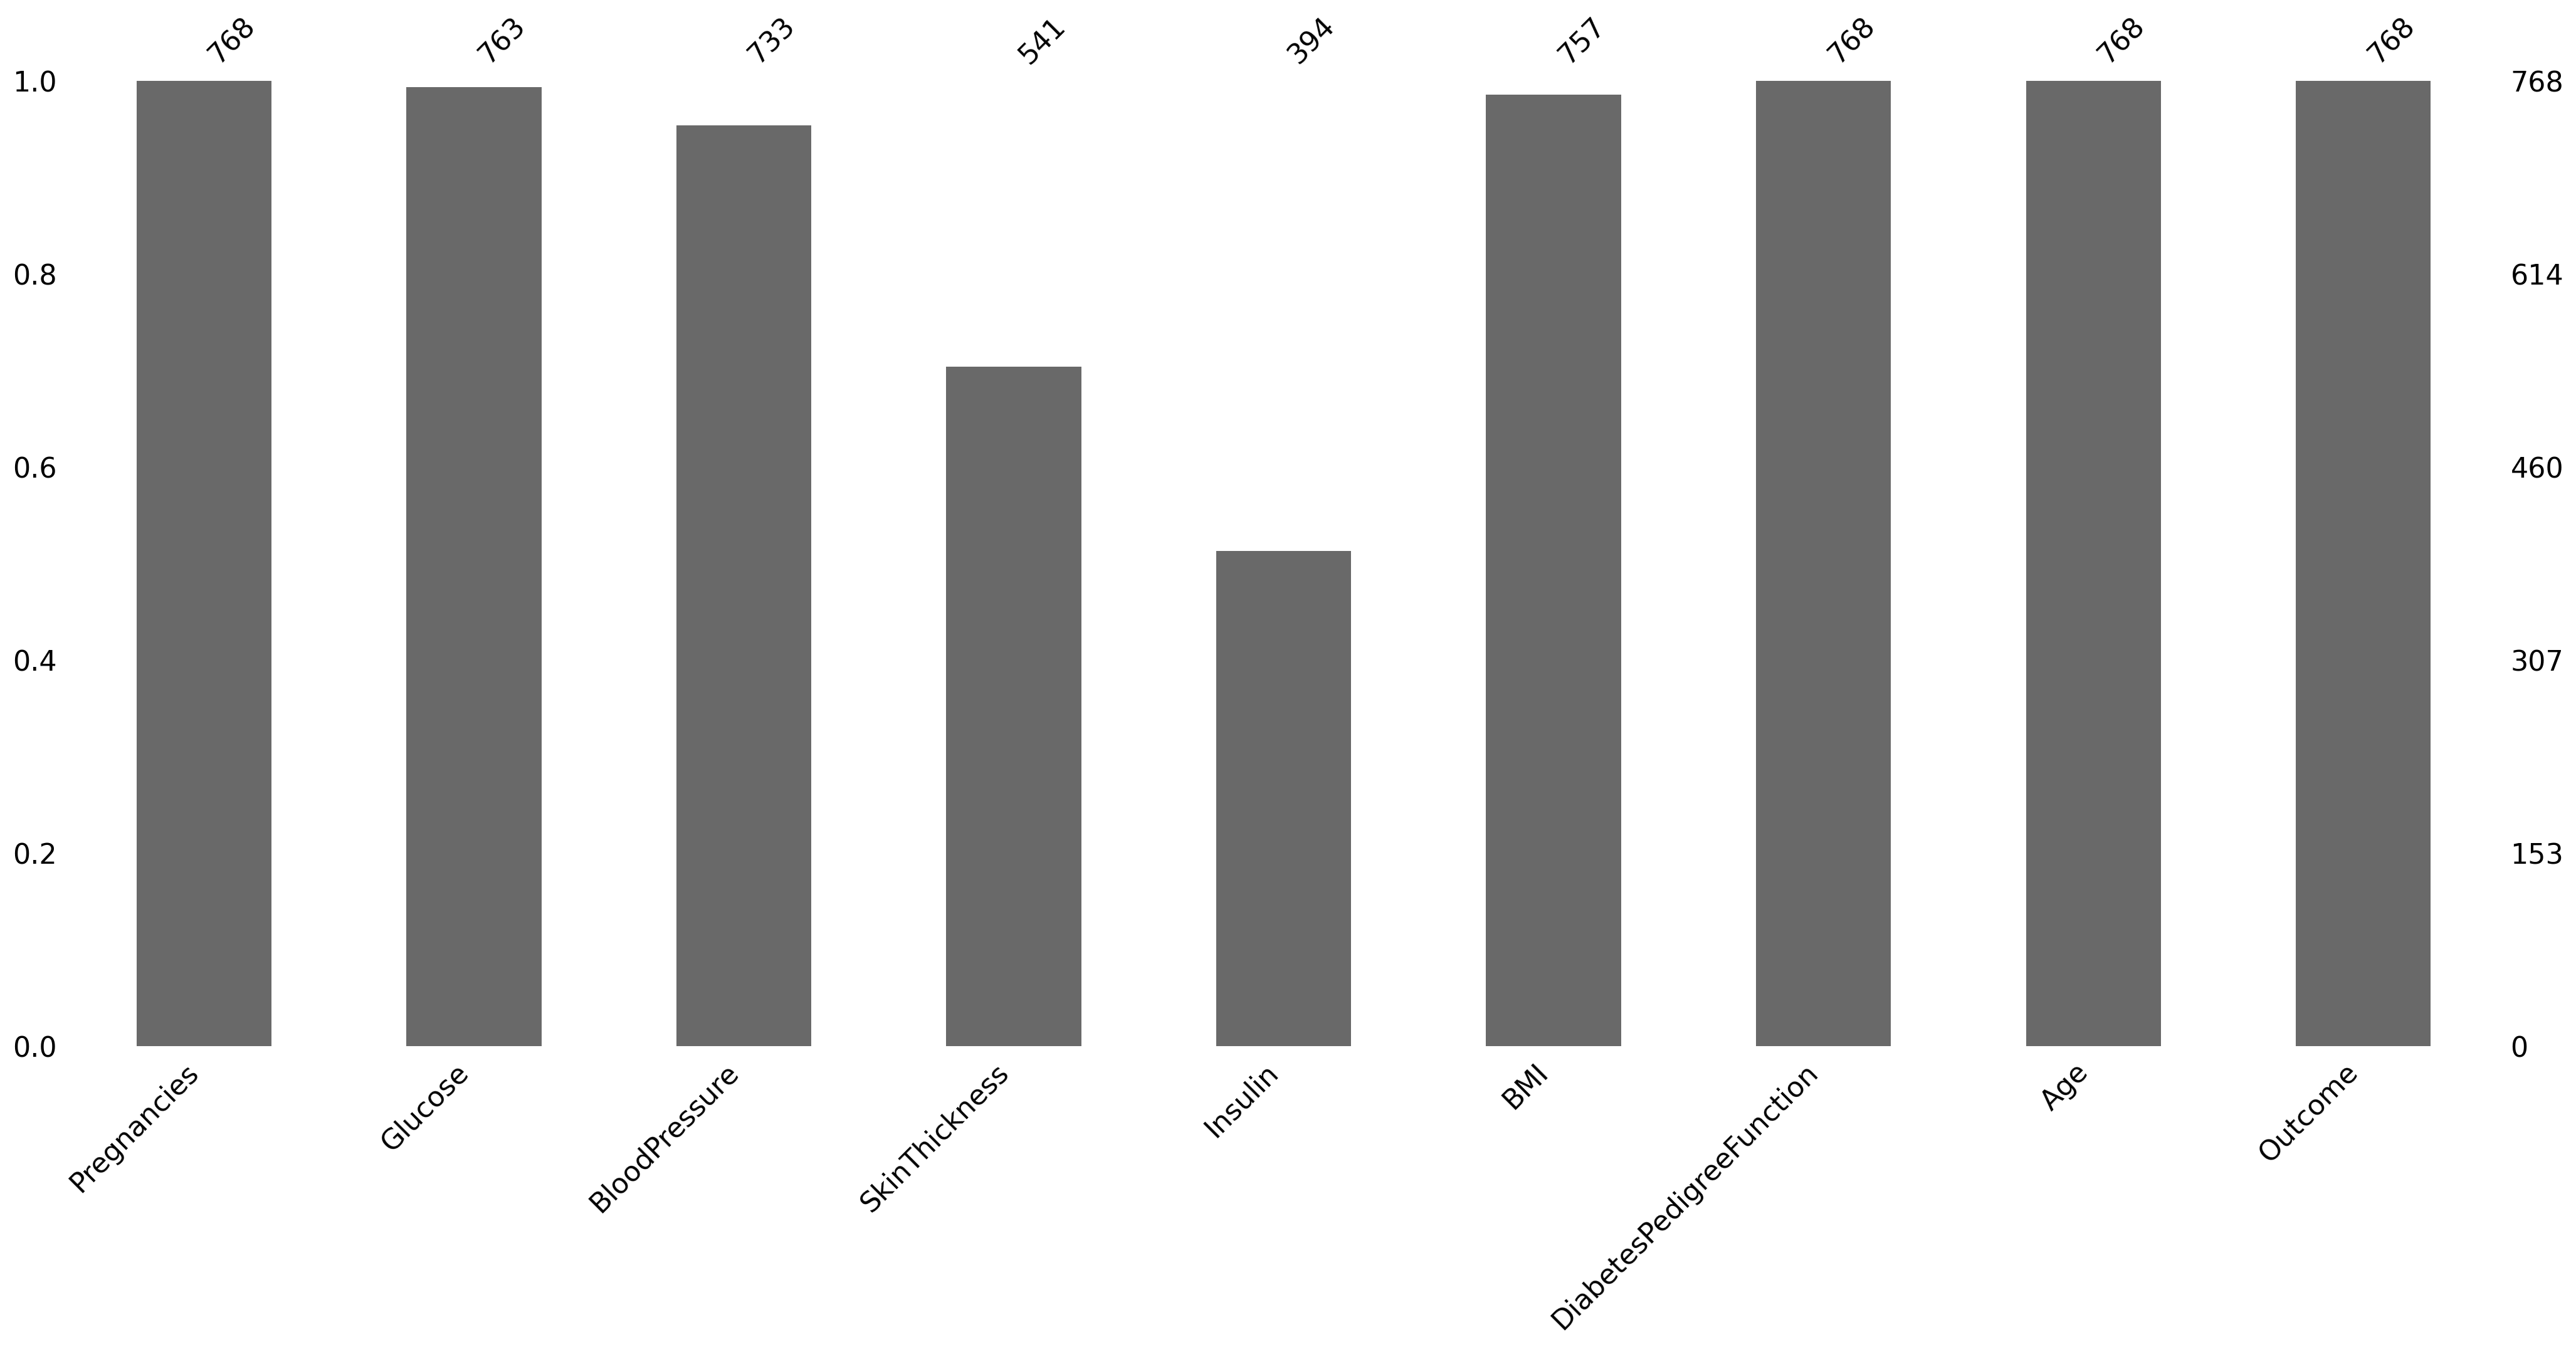

In [451]:
import missingno as msno
msno.bar(df)
plt.show()

In [452]:
def median_target(var):
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby('Outcome')[[var]].median().reset_index()
    return temp

In [453]:
median_target('Glucose')['Glucose'][0]

107.0

In [454]:
columns = df.columns
columns = columns.drop("Outcome")

for col in columns:
    df.loc[(df['Outcome'] == 0 ) & (df[col].isnull()), col] = median_target(col)[col][0]
    df.loc[(df['Outcome'] == 1 ) & (df[col].isnull()), col] = median_target(col)[col][1]

In [455]:
df.loc[(df['Outcome'] == 0) & (df['Glucose'].isnull()), 'Glucose']

Series([], Name: Glucose, dtype: float64)

In [456]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [457]:
# Outlier Analysis
Q1 = df['BloodPressure'].quantile(0.25)
Q3 = df['BloodPressure'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

In [458]:
df['BloodPressure'].describe()

count   768.00
mean     72.39
std      12.11
min      24.00
25%      64.00
50%      72.00
75%      80.00
max     122.00
Name: BloodPressure, dtype: float64

In [459]:
df[df['BloodPressure'] > upper].any(axis=None)

True

In [460]:
for feature in df:
    print(feature)

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DiabetesPedigreeFunction
Age
Outcome


In [461]:
for feature in df.columns.drop('Outcome'):
    Q1 = df[feature].quantile(0.05)
    Q3 = df[feature].quantile(0.95)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    if df[df[feature] > upper].any(axis=None):
        print(f'{feature}: HIGH OUTLIER')
    if df[df[feature] < lower].any(axis=None):
        print(f'{feature}: LOW OUTLIER')
    

SkinThickness: HIGH OUTLIER
Insulin: HIGH OUTLIER


### Feature Engineering

In [462]:
NewBMI = pd.Series(['Underweight', 'Normal', 'Overweight', 'Obesity 1', 'Obesity 2', 'Obesity 3'], dtype='category')
df['NewBMI'] = NewBMI

df.loc[df['BMI'] <= 18.5, 'NewBMI'] = NewBMI[0]
df.loc[(df['BMI'] > 18.5) & (df['BMI'] <=24.9), 'NewBMI'] = NewBMI[1]
df.loc[(df['BMI'] > 24.9) & (df['BMI'] <=29.9), 'NewBMI'] = NewBMI[2]
df.loc[(df['BMI'] > 29.9) & (df['BMI'] <= 34.9), 'NewBMI'] = NewBMI[3]
df.loc[(df['BMI'] > 34.9) & (df['BMI'] <= 39.9), 'NewBMI'] = NewBMI[4]
df.loc[df['BMI'] > 39.9, 'NewBMI'] = NewBMI[5]

In [463]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI
0,6,148.00,72.00,35.00,169.50,33.60,0.63,50,1,Obesity 1
1,1,85.00,66.00,29.00,102.50,26.60,0.35,31,0,Overweight
2,8,183.00,64.00,32.00,169.50,23.30,0.67,32,1,Normal
3,1,89.00,66.00,23.00,94.00,28.10,0.17,21,0,Overweight
4,0,137.00,40.00,35.00,168.00,43.10,2.29,33,1,Obesity 3
5,5,116.00,74.00,27.00,102.50,25.60,0.20,30,0,Overweight
6,3,78.00,50.00,32.00,88.00,31.00,0.25,26,1,Obesity 1
7,10,115.00,70.00,27.00,102.50,35.30,0.13,29,0,Obesity 2
8,2,197.00,70.00,45.00,543.00,30.50,0.16,53,1,Obesity 1
9,8,125.00,96.00,32.00,169.50,34.30,0.23,54,1,Obesity 1


In [464]:
def set_insulin(row):
    if row['Insulin'] >=16 and row['Insulin'] <= 166:
        return 'Normal'
    else:
        return 'Abnormal'

In [465]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI
0,6,148.00,72.00,35.00,169.50,33.60,0.63,50,1,Obesity 1
1,1,85.00,66.00,29.00,102.50,26.60,0.35,31,0,Overweight
2,8,183.00,64.00,32.00,169.50,23.30,0.67,32,1,Normal
3,1,89.00,66.00,23.00,94.00,28.10,0.17,21,0,Overweight
4,0,137.00,40.00,35.00,168.00,43.10,2.29,33,1,Obesity 3


In [466]:
df['NewInsulinScore'] = df.apply(set_insulin, axis=1)

In [467]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulinScore
0,6,148.00,72.00,35.00,169.50,33.60,0.63,50,1,Obesity 1,Abnormal
1,1,85.00,66.00,29.00,102.50,26.60,0.35,31,0,Overweight,Normal
2,8,183.00,64.00,32.00,169.50,23.30,0.67,32,1,Normal,Abnormal
3,1,89.00,66.00,23.00,94.00,28.10,0.17,21,0,Overweight,Normal
4,0,137.00,40.00,35.00,168.00,43.10,2.29,33,1,Obesity 3,Abnormal


In [468]:
NewGlucose = pd.Series(["Low", "Normal", "Overweight", "Secret", "High"], dtype = "category")
df["NewGlucose"] = NewGlucose
df.loc[df["Glucose"] <= 70, "NewGlucose"] = NewGlucose[0]
df.loc[(df["Glucose"] > 70) & (df["Glucose"] <= 99), "NewGlucose"] = NewGlucose[1]
df.loc[(df["Glucose"] > 99) & (df["Glucose"] <= 126), "NewGlucose"] = NewGlucose[2]
df.loc[df["Glucose"] > 126 ,"NewGlucose"] = NewGlucose[3]

In [469]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulinScore,NewGlucose
0,6,148.00,72.00,35.00,169.50,33.60,0.63,50,1,Obesity 1,Abnormal,Secret
1,1,85.00,66.00,29.00,102.50,26.60,0.35,31,0,Overweight,Normal,Normal
2,8,183.00,64.00,32.00,169.50,23.30,0.67,32,1,Normal,Abnormal,Secret
3,1,89.00,66.00,23.00,94.00,28.10,0.17,21,0,Overweight,Normal,Normal
4,0,137.00,40.00,35.00,168.00,43.10,2.29,33,1,Obesity 3,Abnormal,Secret


## One-hot encoding

In [470]:
df = pd.get_dummies(df, columns=['NewBMI', 'NewInsulinScore', 'NewGlucose'], drop_first=True)

In [471]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
0,6,148.00,72.00,35.00,169.50,33.60,0.63,50,1,1,0,0,0,0,0,0,0,0,1
1,1,85.00,66.00,29.00,102.50,26.60,0.35,31,0,0,0,0,1,0,1,0,1,0,0
2,8,183.00,64.00,32.00,169.50,23.30,0.67,32,1,0,0,0,0,0,0,0,0,0,1
3,1,89.00,66.00,23.00,94.00,28.10,0.17,21,0,0,0,0,1,0,1,0,1,0,0
4,0,137.00,40.00,35.00,168.00,43.10,2.29,33,1,0,0,1,0,0,0,0,0,0,1


## Splitting the features and the label

In [472]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']

In [473]:
y

0      1
1      0
2      1
3      0
4      1
5      0
6      1
7      0
8      1
9      1
10     0
11     1
12     0
13     1
14     1
15     1
16     1
17     1
18     0
19     1
20     0
21     0
22     1
23     1
24     1
25     1
26     1
27     0
28     0
29     0
30     0
31     1
32     0
33     0
34     0
35     0
36     0
37     1
38     1
39     1
40     0
41     0
42     0
43     1
44     0
45     1
46     0
47     0
48     1
49     0
50     0
51     0
52     0
53     1
54     0
55     0
56     1
57     0
58     0
59     0
60     0
61     1
62     0
63     0
64     1
65     0
66     1
67     0
68     0
69     0
70     1
71     0
72     1
73     0
74     0
75     0
76     0
77     0
78     1
79     0
80     0
81     0
82     0
83     0
84     1
85     0
86     0
87     0
88     1
89     0
90     0
91     0
92     0
93     1
94     0
95     0
96     0
97     0
98     0
99     1
100    1
101    0
102    0
103    0
104    0
105    0
106    0
107    0
108    0
109    1
110    1
1

## Splitting the data into training and test set

In [474]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [475]:
cols = X_train.columns

In [476]:
index_train = X_train.index
index_test = X_test.index

In [477]:
index_train.shape

(614,)

In [478]:
X_train.index

Int64Index([ 22, 497, 395, 381, 258, 529,  65,   7,  15, 716,
            ...
             53, 689, 614, 657, 628, 456, 435, 398,  48, 294],
           dtype='int64', length=614)

In [479]:
categorical_columns = ['NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
                     'NewInsulinScore_Normal','NewGlucose_Low','NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret']

In [480]:
categorical_df_train = X_train[categorical_columns]
categorical_df_test = X_test[categorical_columns]

In [481]:
categorical_df_train

,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
22,0,1,0,0,0,0,0,0,0,1
497,1,0,0,0,0,1,0,1,0,0
395,0,0,0,1,0,0,0,0,0,1
381,0,0,0,0,0,1,0,0,1,0
258,0,0,0,1,0,0,0,0,0,1
529,0,0,0,0,0,1,0,0,1,0
65,0,0,0,1,0,1,0,1,0,0
7,0,1,0,0,0,1,0,0,1,0
15,1,0,0,0,0,0,0,0,1,0
716,1,0,0,0,0,0,0,0,0,1


In [482]:
categorical_df_test

,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
680,0,0,0,0,0,1,1,0,0,0
607,0,0,0,0,0,1,0,1,0,0
639,0,0,0,0,0,1,0,0,1,0
638,0,0,1,0,0,1,0,1,0,0
295,0,1,0,0,0,1,0,0,0,1
525,0,0,0,0,0,1,0,1,0,0
590,0,0,1,0,0,0,0,0,1,0
418,0,0,0,0,1,1,0,1,0,0
136,1,0,0,0,0,1,0,0,1,0
318,0,1,0,0,0,1,0,0,1,0


In [483]:
numerical_columns = [col for col in X.columns if col not in categorical_columns]

In [484]:
numerical_columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [485]:
X_train = X_train.drop(columns=categorical_columns)
X_test = X_test.drop(columns=categorical_columns)

In [486]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=numerical_columns, index=index_train)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=numerical_columns, index=index_test)

In [487]:
X_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
22,0.80,1.96,1.20,0.57,1.00,0.89,0.20,0.65
497,-0.20,-0.91,0.00,-1.86,-0.40,-0.22,0.46,-0.29
395,-0.20,0.24,-0.93,-0.57,2.57,-0.49,3.25,-0.29
381,-0.60,-0.31,-0.27,-0.86,0.00,-1.36,-0.37,-0.47
258,-0.40,1.89,-1.47,-1.71,4.07,-0.69,0.75,-0.35
529,-0.60,-0.16,-0.47,-0.14,0.00,-0.84,0.76,0.06
65,0.40,-0.46,0.13,-0.14,0.00,-0.34,-0.46,0.12
7,1.40,-0.06,-0.13,-0.14,0.00,0.37,-0.64,-0.06
15,0.80,-0.44,0.17,0.57,1.00,-0.23,0.29,0.12
716,0.00,1.39,0.40,1.57,1.23,0.20,1.58,0.06


In [488]:
X_test

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
680,-0.20,-1.54,-1.07,0.00,-0.86,-0.89,-0.11,-0.47
607,-0.40,-0.64,-0.67,-0.43,-0.92,-1.42,0.29,-0.29
639,-0.40,-0.44,0.13,-2.29,-0.84,-1.42,-0.60,-0.12
638,0.80,-0.51,0.27,0.57,-0.17,1.01,1.32,0.12
295,0.60,0.84,-0.67,0.43,0.26,0.40,0.84,-0.12
525,0.00,-0.76,-0.80,-1.43,0.00,-1.16,0.18,-0.53
590,1.60,-0.16,0.80,1.71,1.00,1.68,1.46,0.88
418,-0.40,-0.86,-0.27,-0.14,0.00,-1.57,0.66,-0.18
136,-0.60,-0.44,-0.13,-0.29,-0.78,-0.14,0.59,-0.53
318,0.00,-0.06,-0.40,1.57,0.56,0.69,-0.60,-0.12


In [489]:
X_train = pd.concat([X_train, categorical_df_train], axis=1)
X_test = pd.concat([X_test, categorical_df_test], axis=1)

In [490]:
X_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
22,0.80,1.96,1.20,0.57,1.00,0.89,0.20,0.65,0,1,0,0,0,0,0,0,0,1
497,-0.20,-0.91,0.00,-1.86,-0.40,-0.22,0.46,-0.29,1,0,0,0,0,1,0,1,0,0
395,-0.20,0.24,-0.93,-0.57,2.57,-0.49,3.25,-0.29,0,0,0,1,0,0,0,0,0,1
381,-0.60,-0.31,-0.27,-0.86,0.00,-1.36,-0.37,-0.47,0,0,0,0,0,1,0,0,1,0
258,-0.40,1.89,-1.47,-1.71,4.07,-0.69,0.75,-0.35,0,0,0,1,0,0,0,0,0,1
529,-0.60,-0.16,-0.47,-0.14,0.00,-0.84,0.76,0.06,0,0,0,0,0,1,0,0,1,0
65,0.40,-0.46,0.13,-0.14,0.00,-0.34,-0.46,0.12,0,0,0,1,0,1,0,1,0,0
7,1.40,-0.06,-0.13,-0.14,0.00,0.37,-0.64,-0.06,0,1,0,0,0,1,0,0,1,0
15,0.80,-0.44,0.17,0.57,1.00,-0.23,0.29,0.12,1,0,0,0,0,0,0,0,1,0
716,0.00,1.39,0.40,1.57,1.23,0.20,1.58,0.06,1,0,0,0,0,0,0,0,0,1


In [491]:
X_test

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
680,-0.20,-1.54,-1.07,0.00,-0.86,-0.89,-0.11,-0.47,0,0,0,0,0,1,1,0,0,0
607,-0.40,-0.64,-0.67,-0.43,-0.92,-1.42,0.29,-0.29,0,0,0,0,0,1,0,1,0,0
639,-0.40,-0.44,0.13,-2.29,-0.84,-1.42,-0.60,-0.12,0,0,0,0,0,1,0,0,1,0
638,0.80,-0.51,0.27,0.57,-0.17,1.01,1.32,0.12,0,0,1,0,0,1,0,1,0,0
295,0.60,0.84,-0.67,0.43,0.26,0.40,0.84,-0.12,0,1,0,0,0,1,0,0,0,1
525,0.00,-0.76,-0.80,-1.43,0.00,-1.16,0.18,-0.53,0,0,0,0,0,1,0,1,0,0
590,1.60,-0.16,0.80,1.71,1.00,1.68,1.46,0.88,0,0,1,0,0,0,0,0,1,0
418,-0.40,-0.86,-0.27,-0.14,0.00,-1.57,0.66,-0.18,0,0,0,0,1,1,0,1,0,0
136,-0.60,-0.44,-0.13,-0.29,-0.78,-0.14,0.59,-0.53,1,0,0,0,0,1,0,0,1,0
318,0.00,-0.06,-0.40,1.57,0.56,0.69,-0.60,-0.12,0,1,0,0,0,1,0,0,1,0


## Model Building

In [492]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('SVM', SVC()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('LightGBM', LGBMClassifier()))

In [493]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=0, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    
    msg = f"{name}: {cv_results.mean()} ({cv_results.std()})"
    print(msg)

LR: 0.8501057641459544 (0.048472478007670246)
SVM: 0.8500528820729774 (0.04167604768085288)
CART: 0.8352987837123216 (0.04760083532022561)
RF: 0.8858011634056053 (0.04603572770962479)
KNN: 0.8337387625594925 (0.05103500888619948)
GBC: 0.874457958751983 (0.039129482335211525)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 192, number of negative: 360
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 552, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347826 -> initscore=-0.628609
[LightGBM] [Info] Start training from score -0.628609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 193, number of negative: 360
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 553, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349005 -> initscore=-0.623414
[LightGBM] [Info] Start training from score -0.623414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

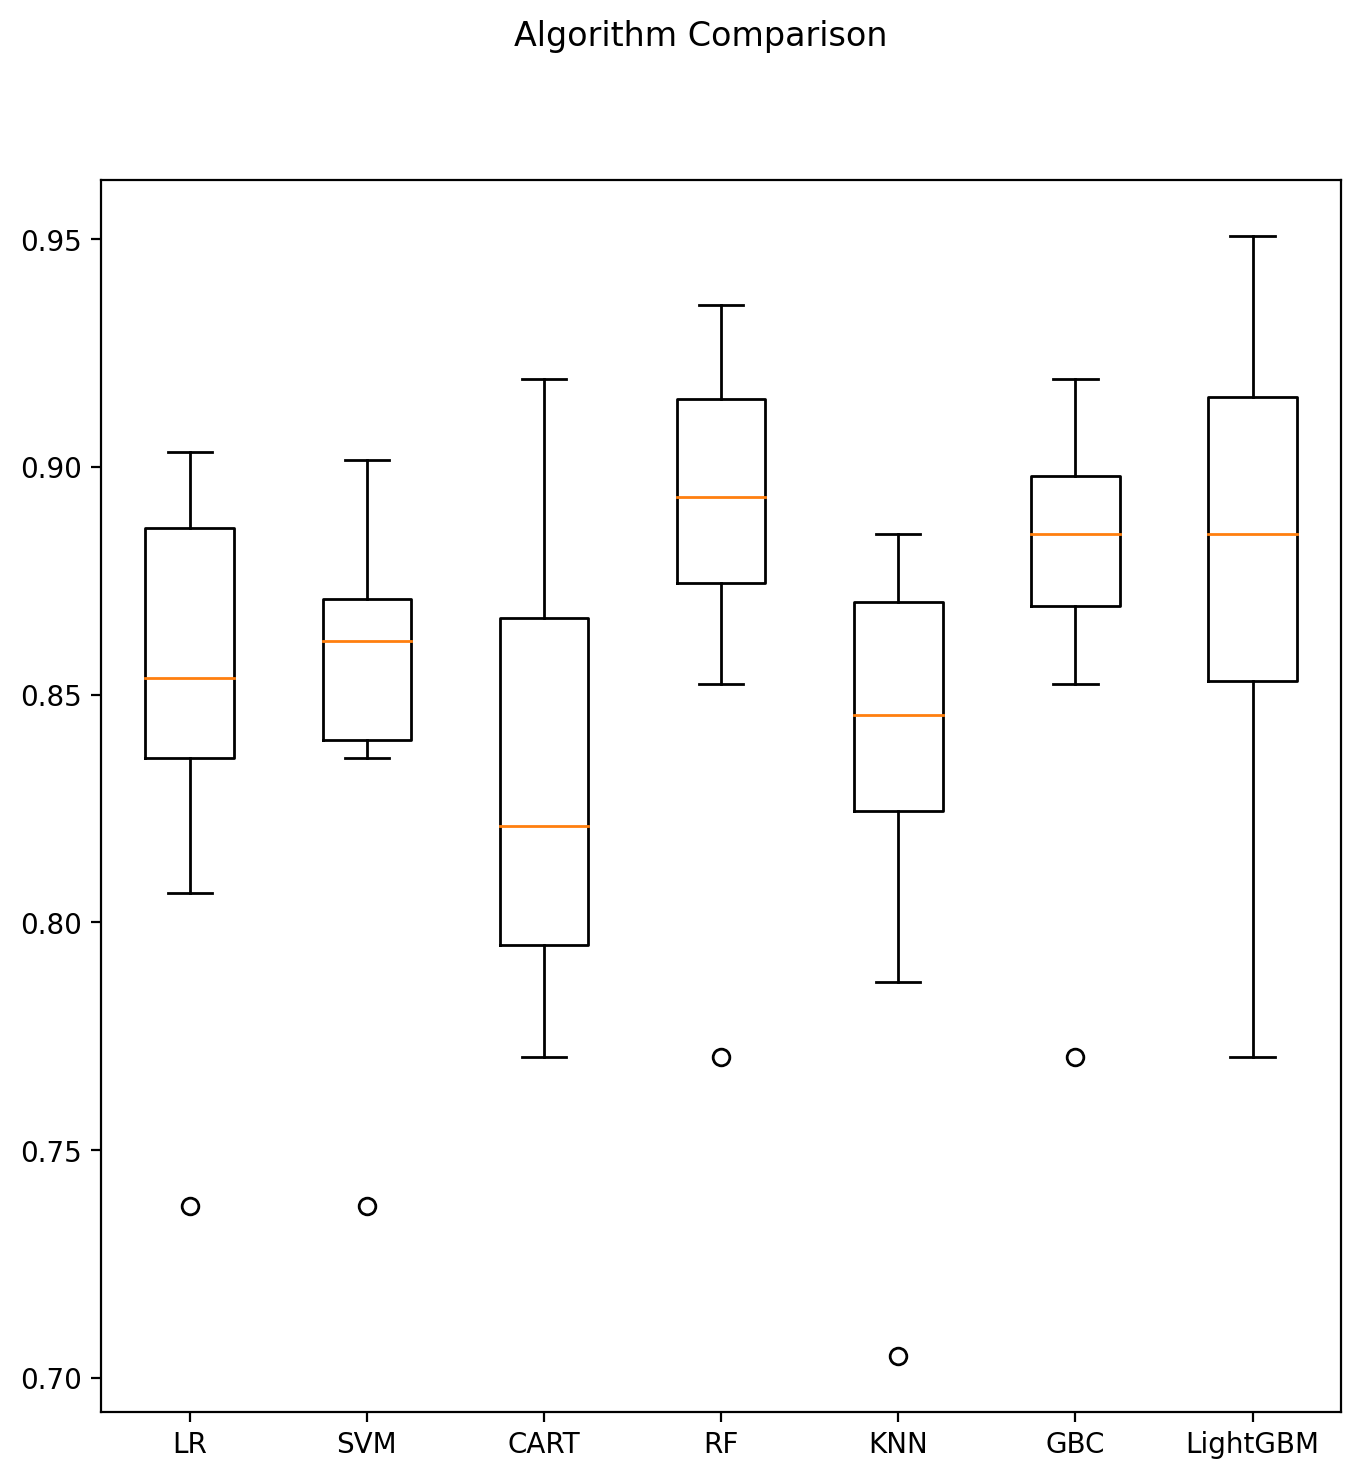

In [494]:
# boxplot for model comparison
fig = plt.figure(figsize=(8, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

RF, GBC, LightGBM show promise

In [495]:
# RF tuning
n_estimators = [100, 200, 500, 1000]  # Number of trees in the forest
max_depth = [3, 5, 8, None]      # Maximum depth of the tree
min_samples_split = [2, 5, 10, 30]      # Minimum number of samples required to split an internal node
min_samples_leaf = [1, 2, 4]        # Minimum number of samples required to be at a leaf node
max_features = [3, 5, 7]
param_grid = dict(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

model = RandomForestClassifier(random_state=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold, n_jobs = -1, verbose = 2)
grid_result = grid.fit(X_train, y_train)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


In [496]:
print("Best Hyperparameters: ", grid_result.best_params_)
print("Best Accuracy: {:.2f}%".format(grid_result.best_score_ * 100))

Best Hyperparameters:  {'max_depth': 8, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best Accuracy: 90.07%


In [497]:
# RF: Tuned Model
rf_tuned = RandomForestClassifier(**grid_result.best_params_)

In [498]:
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=7, n_estimators=500)

In [499]:
cross_val_score(rf_tuned, X_train, y_train, cv = 10).mean()

0.890692755156002

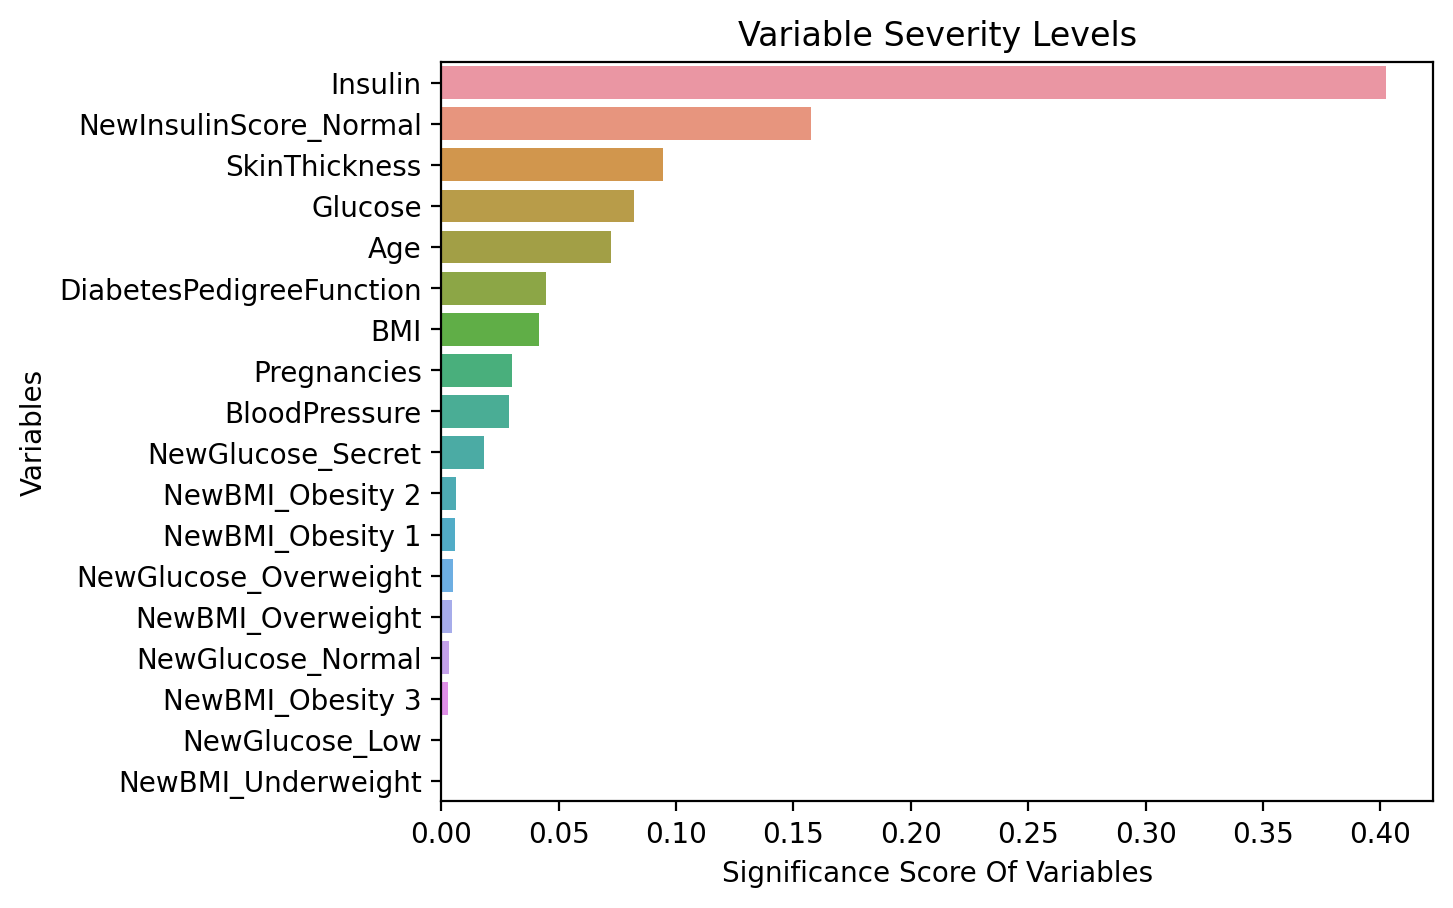

In [500]:
feature_imp = pd.Series(rf_tuned.feature_importances_,
                        index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Significance Score Of Variables')
plt.ylabel('Variables')
plt.title("Variable Severity Levels")
plt.show()

In [505]:
# Evaluation on test set
y_pred_test = rf_tuned.predict(X_test)
print(cross_val_score(rf_tuned, X_test, y_test, cv=10).mean())
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

0.81125
[[93  7]
 [17 37]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       100
           1       0.84      0.69      0.76        54

    accuracy                           0.84       154
   macro avg       0.84      0.81      0.82       154
weighted avg       0.84      0.84      0.84       154



In [506]:
# GBC tuning
n_estimators = [50, 100, 150, 200]        # Number of boosting stages to be run
learning_rate = [0.01, 0.05, 0.1, 0.2]   # Step size shrinkage used to prevent overfitting
max_depth = [3, 5, 7, 9]                 # Maximum depth of the individual estimators
min_samples_split = [2, 5, 10]           # Minimum number of samples required to split an internal node
min_samples_leaf = [1, 2, 4]             # Minimum number of samples required to be at a leaf node
param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

model = GradientBoostingClassifier(random_state=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(X_train, y_train)

print("Best Hyperparameters: ", grid_result.best_params_)
print("Best Accuracy: {:.2f}%".format(grid_result.best_score_ * 100))

Best Hyperparameters:  {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Accuracy: 90.24%


In [509]:
# GBC: Tuned Model
gbc_tuned = GradientBoostingClassifier(**grid_result.best_params_)
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, min_samples_leaf=2,
                           min_samples_split=5)

In [510]:
cross_val_score(rf_tuned, X_train, y_train, cv = 10).mean()

0.8923056583818084

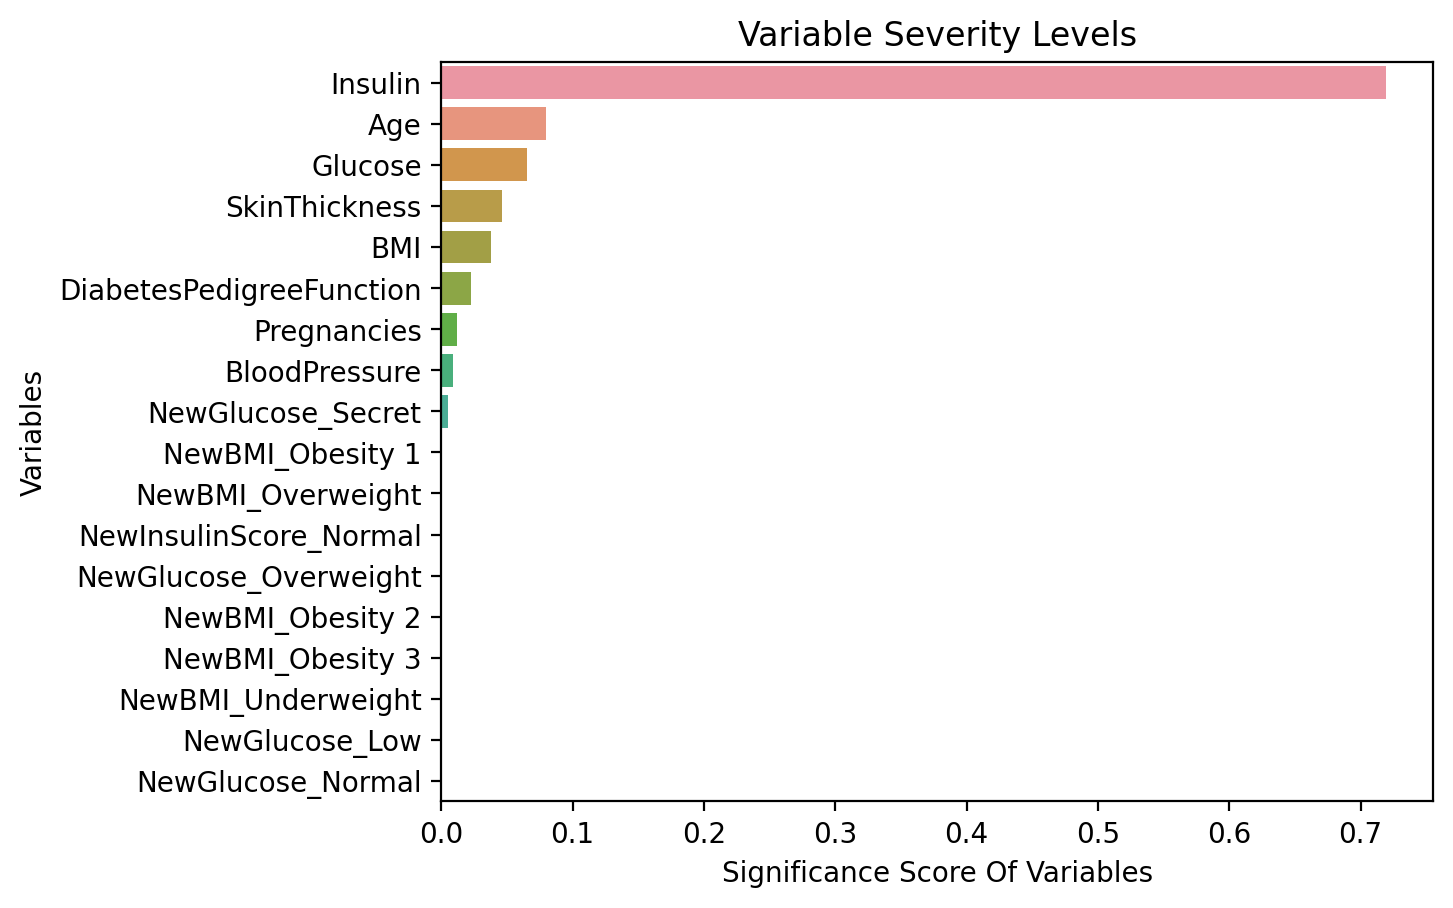

In [511]:
feature_imp = pd.Series(gbc_tuned.feature_importances_,
                        index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Significance Score Of Variables')
plt.ylabel('Variables')
plt.title("Variable Severity Levels")
plt.show()

In [512]:
# Evaluation on test set
y_pred_test = gbc_tuned.predict(X_test)
print(cross_val_score(gbc_tuned, X_test, y_test, cv=10).mean())
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

0.8120833333333334
[[95  5]
 [14 40]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       100
           1       0.89      0.74      0.81        54

    accuracy                           0.88       154
   macro avg       0.88      0.85      0.86       154
weighted avg       0.88      0.88      0.87       154



In [ ]:
# Tuning LightGBM
param_grid = {
    'n_estimators': [50, 100, 150, 200],        # Number of boosting stages to be run
    'learning_rate': [0.01, 0.05, 0.1, 0.2],    # Step size shrinkage used to prevent overfitting
    'max_depth': [3, 5, 7, 9],                  # Maximum depth of the individual estimators
    'num_leaves': [15, 31, 63, 127],            # Maximum number of leaves in one tree
    'min_child_samples': [1, 5, 10],            # Minimum number of data needed in a child (leaf)
}

model = LGBMClassifier(random_state=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(X_train, y_train)

print("Best Hyperparameters: ", grid_result.best_params_)
print("Best Accuracy: {:.2f}%".format(grid_result.best_score_ * 100))

In [ ]:
# RF: Tuned Model
lgb_tuned = LighGBMClassifier(**grid_result.best_params_)
lgb_tuned.fit(X_train, y_train)

In [ ]:
cross_val_score(lgb_tuned, X_train, y_train, cv = 10).mean()

In [ ]:
feature_imp = pd.Series(lgb_tuned.feature_importances_,
                        index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Significance Score Of Variables')
plt.ylabel('Variables')
plt.title("Variable Severity Levels")
plt.show()

In [ ]:
# Evaluation on test set
y_pred_test = lgb_tuned.predict(X_test)
print(cross_val_score(lgb_tuned, X_test, y_test, cv=10).mean())
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))